In [12]:
#Importing libraries
import math
import yfinance as yf
import numpy as np
import pandas as pd
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM,Dense
import pandas_datareader as web
from __future__ import print_function
from keras.layers import Bidirectional
import cv2
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from keras.layers import Dense , Activation, Dropout, Conv2D, Flatten, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.metrics import AUC, Accuracy
from tensorflow.keras.utils import to_categorical, plot_model
import os,datetime
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array
from imblearn.over_sampling import SMOTE
from keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from datetime import datetime
from sklearn import preprocessing
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.metrics import make_scorer, accuracy_score, classification_report, confusion_matrix, mean_squared_error
import matplotlib as mpl
import matplotlib.pylab as pylab
import seaborn as sns
from pandas import get_dummies
import xgboost as xgb
import scipy
import json
import sys
import csv
import os
import tqdm
import keras
from tqdm import tqdm_notebook
from keras.layers.normalization.batch_normalization import BatchNormalization
from tensorflow.keras import backend as K
from random import randint, seed
from sklearn.metrics import *
from math import sqrt
K.clear_session()
plt.style.use("fivethirtyeight")

In [13]:
#Reading data
df = yf.download('KOZAL.IS', start = '2010-02-12', end='2022-05-18')
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-02-12,13.081795,14.262108,12.983436,14.163748,11.704618,20736967
2010-02-15,13.868670,13.967029,13.573592,13.573592,11.216925,2734869
2010-02-16,13.475233,14.557186,13.278514,14.065389,11.623335,6004003
2010-02-17,14.065389,14.262108,13.868670,13.967029,11.542052,1264495
2010-02-18,14.163748,14.262108,13.868670,13.967029,11.542052,1234503


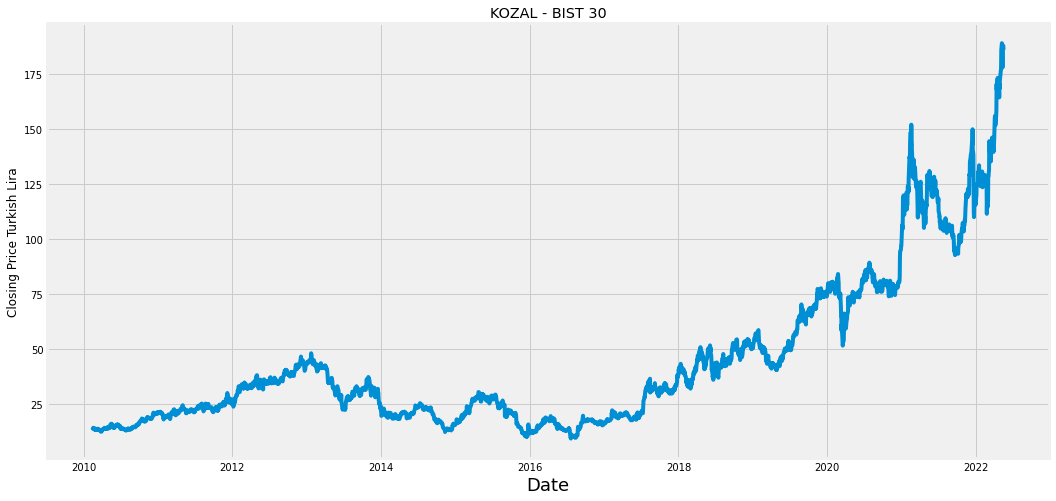

In [14]:
#Filtering data
data = df.filter(["Close"])
#Visualization
plt.figure(figsize=(16,8))
plt.plot(data["Close"])
plt.xlabel("Date",fontsize=18)
plt.ylabel("Closing Price Turkish Lira")
plt.title("KOZAL - BIST 30")
plt.show()

In [15]:
#Creating a new DataFrame with the only Close column
data = df.filter(["Close"])
#Converting the dataframe to a numpy array
dataset = data.values
#Getting the number of rows to train the model on
training_data_len = math.ceil(len(dataset) * 0.8)
print(training_data_len)

2538


In [16]:
#Scaling the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.02768441],
       [0.02440613],
       [0.02713803],
       ...,
       [0.99333409],
       [0.99333409],
       [0.98333518]])

In [17]:
#Creating the scaled training data set
train_data = scaled_data[0:training_data_len,:]
#Splitting the data into x_train and y_train data sets

x_train = []
y_train = []

for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])
    if i <= 60:
        print(x_train)
        print(y_train)
        print()

[array([0.02768441, 0.02440613, 0.02713803, 0.02659165, 0.02659165,
       0.02659165, 0.02604527, 0.02604527, 0.02222061, 0.02276699,
       0.02222061, 0.02331337, 0.02440613, 0.02440613, 0.02331337,
       0.02331337, 0.02331337, 0.02276699, 0.02222061, 0.02495251,
       0.02222061, 0.02222061, 0.02222061, 0.02276699, 0.02167423,
       0.02058147, 0.02003509, 0.02003509, 0.01839595, 0.01894233,
       0.01784957, 0.01730319, 0.02112785, 0.02058147, 0.02112785,
       0.02331337, 0.02331337, 0.02331337, 0.02331337, 0.02385975,
       0.02440613, 0.02713803, 0.02659165, 0.02604527, 0.0254989 ,
       0.02385975, 0.02440613, 0.0254989 , 0.02659165, 0.02713803,
       0.02713803, 0.02768441, 0.02495251, 0.02440613, 0.02604527,
       0.02932355, 0.02932355, 0.02986994, 0.02823079, 0.02877717])]
[0.026045274112979036]



In [18]:
#Converting the x_train and y_train to numpy arrays
x_train,y_train = np.array(x_train),np.array(y_train)

In [19]:
#Reshaping the data
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
x_train.shape

(2478, 60, 1)

In [20]:
#Building the LSTM Model
model = Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [21]:
ch_p_den = ModelCheckpoint(filepath="model_den.h5", monitor='val_loss', save_weights_only=True)

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 25)                1275      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


In [23]:
AUTO = tf.data.experimental.AUTOTUNE
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

def build_lrfn(lr_start=0.00001, lr_max=0.000075, 
               lr_min=0.000001, lr_rampup_epochs=20, 
               lr_sustain_epochs=0, lr_exp_decay=.8):
    lr_max = lr_max * strategy.num_replicas_in_sync

    def lrfn(epoch):
        if epoch < lr_rampup_epochs:
            lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
        elif epoch < lr_rampup_epochs + lr_sustain_epochs:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) * lr_exp_decay**(epoch - lr_rampup_epochs - lr_sustain_epochs) + lr_min
        return lr
    
    return lrfn

lrfn = build_lrfn()
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=1)

In [24]:
#Compiling the model
model.compile(optimizer="adam",loss="mean_squared_error",metrics=['mse', 'mae', 'mape','accuracy'])

In [26]:
#Training the model
#model.fit(x_train,y_train,batch_size=32, epochs=10,callbacks=[lr_schedule, ch_p_den])
model.fit(x_train,y_train,batch_size=32, epochs=20,verbose="auto")

Epoch 1/20
78/78 [==============================] - 2s 31ms/step - loss: 4.1577e-05 - mse: 4.1577e-05 - mae: 0.0048 - mape: 4195.1909 - accuracy: 4.0355e-04
Epoch 2/20
78/78 [==============================] - 2s 30ms/step - loss: 3.6677e-05 - mse: 3.6677e-05 - mae: 0.0044 - mape: 3996.2917 - accuracy: 4.0355e-04
Epoch 3/20
78/78 [==============================] - 2s 30ms/step - loss: 4.0769e-05 - mse: 4.0769e-05 - mae: 0.0047 - mape: 2854.3403 - accuracy: 4.0355e-04
Epoch 4/20
78/78 [==============================] - 2s 30ms/step - loss: 3.5051e-05 - mse: 3.5051e-05 - mae: 0.0043 - mape: 2928.8521 - accuracy: 4.0355e-04
Epoch 5/20
78/78 [==============================] - 2s 30ms/step - loss: 3.5493e-05 - mse: 3.5493e-05 - mae: 0.0043 - mape: 2789.9194 - accuracy: 4.0355e-04
Epoch 6/20
78/78 [==============================] - 2s 30ms/step - loss: 4.1576e-05 - mse: 4.1576e-05 - mae: 0.0048 - mape: 753.7432 - accuracy: 4.0355e-04
Epoch 7/20
78/78 [==============================] - 2s 31ms

In [27]:
plot_model(model, to_file='C:/Users/by/Documents/model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [28]:
#Creating a new array containing scaled values from index
test_data = scaled_data[training_data_len - 60:, :]
#Creating the data sets x_test and y_test

x_test = []
y_test = dataset[training_data_len:,:]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

In [29]:
#Converting the data to a numpy array
x_test = np.array(x_test)

In [30]:
#Reshaping the data
x_test = np.reshape(x_test,(x_test.shape[0], x_test.shape[1], 1))

In [31]:
#Getting the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

20/20 [==============================] - 1s 12ms/step


In [32]:
#Getting the root mean squared error (RMSE)
rmse = np.sqrt( np.mean(predictions - y_test)**2)
rmse

0.43497548268796515

8.821904429052482
0.9885881376110681
2.970169090986653
2.0803747869064377


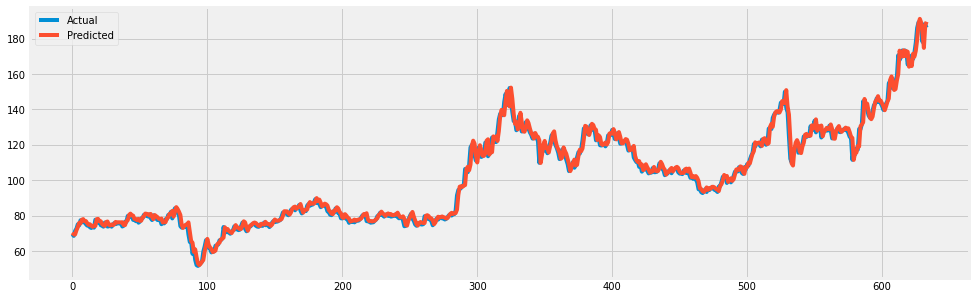

In [33]:
plt.rcParams['figure.figsize'] = (15,5)

MSE = mean_squared_error(y_test, predictions)
R2 = r2_score(y_test, predictions)
RMSE = sqrt(mean_squared_error(y_test, predictions))
MAE = mean_absolute_error(y_test, predictions)

print(MSE)
print(R2)
print(RMSE)
print(MAE)

#plotting predicted test value vs actual test value
plt.plot(y_test, label = 'Actual')
plt.plot(predictions, label = 'Predicted')
plt.legend()
plt.show()

C:\Users\by\AppData\Local\Temp\ipykernel_5044\3219983945.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid["Predictions"] = predictions


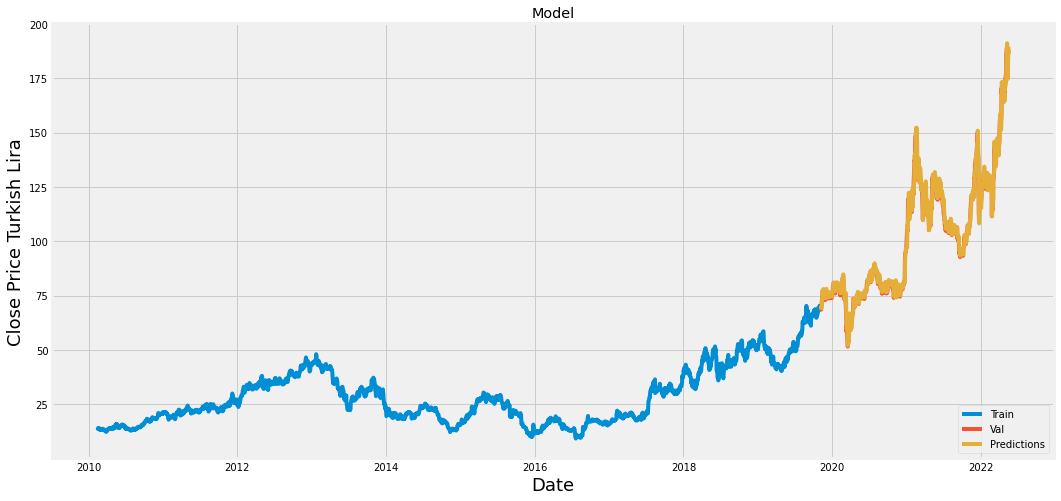

In [34]:
#Plotting the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid["Predictions"] = predictions
#Visualizing the data
plt.figure(figsize=(16,8))
plt.title("Model")
plt.xlabel("Date",fontsize=18)
plt.ylabel("Close Price Turkish Lira",fontsize=18)
plt.plot(train["Close"])
plt.plot(valid[["Close","Predictions"]])
plt.legend(["Train","Val","Predictions"], loc="lower right")
plt.show()

In [35]:
model2 = Sequential([
layers.Rescaling(1./255.,input_shape=(x_train.shape[1],1)),
layers.SimpleRNN(50,return_sequences=True,input_shape=(x_train.shape[1],1)),
layers.SimpleRNN(50, return_sequences=True),
layers.Flatten(),
layers.Dense(25),
layers.Dense(1),
])
model2.build()

In [36]:
model2.compile(optimizer="adam",loss="mean_squared_error")

In [37]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 60, 1)             0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 60, 50)            2600      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 60, 50)            5050      
                                                                 
 flatten (Flatten)           (None, 3000)              0         
                                                                 
 dense_2 (Dense)             (None, 25)                75025     
                                                                 
 dense_3 (Dense)             (None, 1)                 26        
                                                                 
Total params: 82,701
Trainable params: 82,701
Non-trai

In [38]:
model2.fit(x_train,y_train,batch_size=32, epochs=20,verbose="auto")

Epoch 1/20
78/78 [==============================] - 2s 13ms/step - loss: 0.0162
Epoch 2/20
78/78 [==============================] - 1s 13ms/step - loss: 0.0048
Epoch 3/20
78/78 [==============================] - 1s 13ms/step - loss: 0.0044
Epoch 4/20
78/78 [==============================] - 1s 13ms/step - loss: 0.0044
Epoch 5/20
78/78 [==============================] - 1s 13ms/step - loss: 0.0037
Epoch 6/20
78/78 [==============================] - 1s 13ms/step - loss: 0.0039
Epoch 7/20
78/78 [==============================] - 1s 13ms/step - loss: 0.0028
Epoch 8/20
78/78 [==============================] - 1s 13ms/step - loss: 0.0025
Epoch 9/20
78/78 [==============================] - 1s 13ms/step - loss: 0.0023
Epoch 10/20
78/78 [==============================] - 1s 13ms/step - loss: 0.0023
Epoch 11/20
78/78 [==============================] - 1s 13ms/step - loss: 0.0018
Epoch 12/20
78/78 [==============================] - 1s 13ms/step - loss: 0.0015
Epoch 13/20
78/78 [==================

In [40]:
plot_model(model2, to_file='C:/Users/by/Documents/model2_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [41]:
#Creating new array containing scaled values from index
test_data = scaled_data[training_data_len - 60:, :]
#Creating the data sets x_test and y_test

x_test = []
y_test = dataset[training_data_len:,:]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

In [42]:
#Converting the data to a numpy array
x_test = np.array(x_test)

In [43]:
#Reshaping the data
x_test = np.reshape(x_test,(x_test.shape[0], x_test.shape[1], 1))

In [44]:
#Getting the models predicted price values
predictions = model2.predict(x_test)
predictions = scaler.inverse_transform(predictions)

20/20 [==============================] - 0s 7ms/step


In [45]:
rmse = np.sqrt( np.mean(predictions - y_test)**2)
rmse

17.047638703595954

C:\Users\by\AppData\Local\Temp\ipykernel_5044\2178876244.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid["Predictions"] = predictions


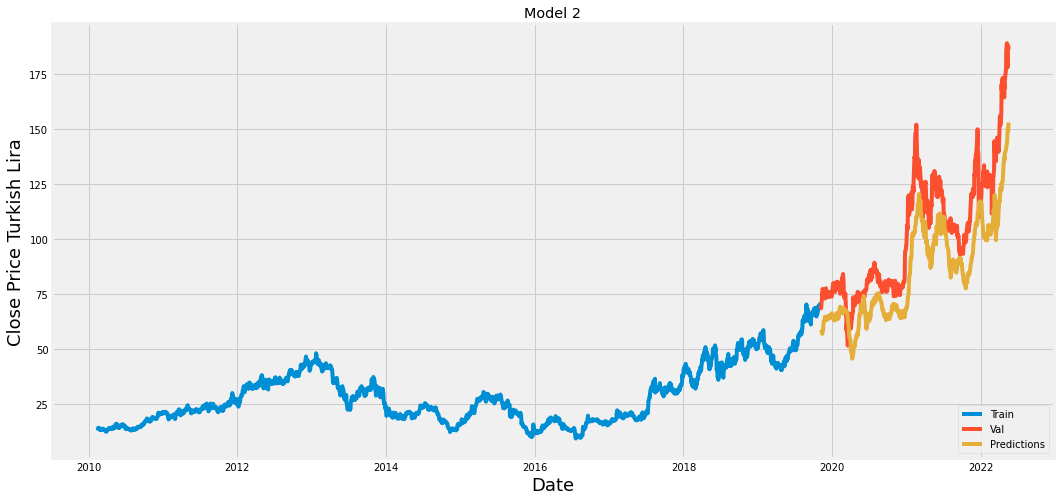

In [46]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid["Predictions"] = predictions
#Visualizing the data
plt.figure(figsize=(16,8))
plt.title("Model 2")
plt.xlabel("Date",fontsize=18)
plt.ylabel("Close Price Turkish Lira",fontsize=18)
plt.plot(train["Close"])
plt.plot(valid[["Close","Predictions"]])
plt.legend(["Train","Val","Predictions"], loc="lower right")
plt.show()

In [47]:
model_gru = Sequential()
# First GRU layer with Dropout regularisation
model_gru.add(GRU(units=50, return_sequences=True, input_shape=(x_train.shape[1],1), activation='tanh'))
model_gru.add(Dropout(0.2))
# Second GRU layer
model_gru.add(GRU(units=50, return_sequences=True, input_shape=(x_train.shape[1],1), activation='tanh'))
model_gru.add(Dropout(0.2))
# Third GRU layer
model_gru.add(GRU(units=50, return_sequences=True, input_shape=(x_train.shape[1],1), activation='tanh'))
model_gru.add(Dropout(0.2))
# Fourth GRU layer
model_gru.add(GRU(units=50, activation='tanh'))
model_gru.add(Dropout(0.2))
# The output layer
model_gru.add(Dense(units=1))
# Compiling the RNN
model_gru.compile(optimizer="SGD",loss='mean_squared_error')
# Fitting to the training set

In [48]:
model_gru.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 60, 50)            7950      
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 gru_1 (GRU)                 (None, 60, 50)            15300     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 gru_2 (GRU)                 (None, 60, 50)            15300     
                                                                 
 dropout_2 (Dropout)         (None, 60, 50)            0         
                                                                 
 gru_3 (GRU)                 (None, 50)               

In [49]:
gru_history = model_gru.fit(x_train, y_train, epochs=20,verbose="auto", batch_size=32, shuffle=False)

Epoch 1/20
78/78 [==============================] - 10s 63ms/step - loss: 0.0031
Epoch 2/20
78/78 [==============================] - 5s 64ms/step - loss: 0.0045
Epoch 3/20
78/78 [==============================] - 5s 64ms/step - loss: 0.0044
Epoch 4/20
78/78 [==============================] - 5s 64ms/step - loss: 0.0043
Epoch 5/20
78/78 [==============================] - 5s 63ms/step - loss: 0.0042
Epoch 6/20
78/78 [==============================] - 5s 63ms/step - loss: 0.0041
Epoch 7/20
78/78 [==============================] - 5s 63ms/step - loss: 0.0040
Epoch 8/20
78/78 [==============================] - 5s 63ms/step - loss: 0.0039
Epoch 9/20
78/78 [==============================] - 5s 64ms/step - loss: 0.0038
Epoch 10/20
78/78 [==============================] - 5s 63ms/step - loss: 0.0037
Epoch 11/20
78/78 [==============================] - 5s 64ms/step - loss: 0.0036
Epoch 12/20
78/78 [==============================] - 5s 64ms/step - loss: 0.0035
Epoch 13/20
78/78 [=================

In [50]:
plot_model(model_gru, to_file='C:/Users/by/Documents/model_gru_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


393.4138135227214
0.4910867219280888
19.83466192105934
17.34392291890334


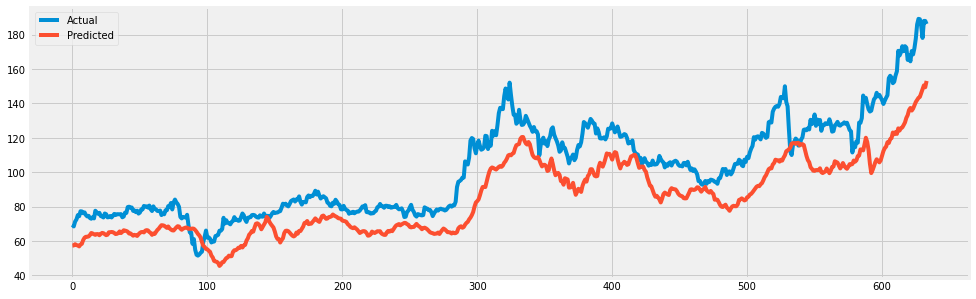

In [51]:
plt.rcParams['figure.figsize'] = (15,5)

MSE = mean_squared_error(y_test, predictions)
R2 = r2_score(y_test, predictions)
RMSE = sqrt(mean_squared_error(y_test, predictions))
MAE = mean_absolute_error(y_test, predictions)

print(MSE)
print(R2)
print(RMSE)
print(MAE)

#Plotting predicted test value vs actual test value
plt.plot(y_test, label = 'Actual')
plt.plot(predictions, label = 'Predicted')
plt.legend()
plt.show()

C:\Users\by\AppData\Local\Temp\ipykernel_5044\2178876244.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid["Predictions"] = predictions


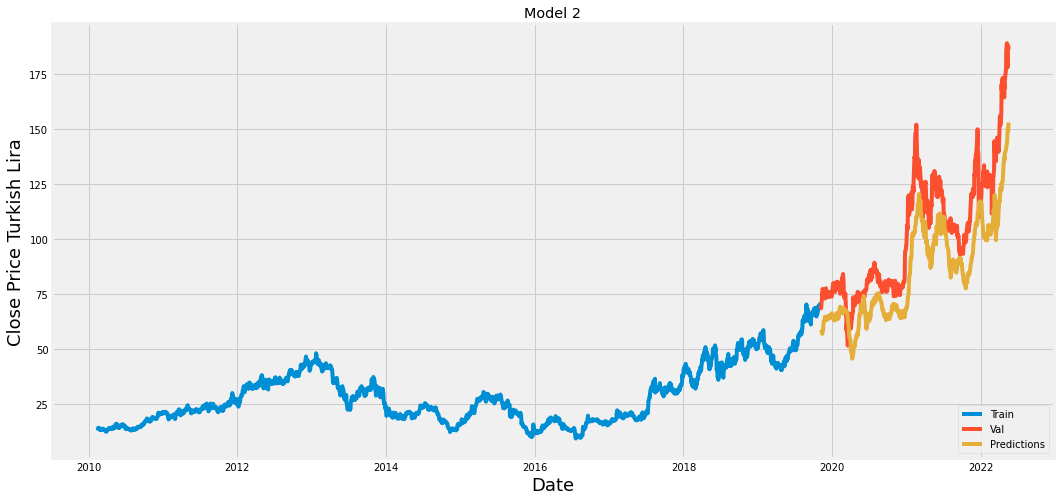

In [52]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid["Predictions"] = predictions
#Visualizing the data
plt.figure(figsize=(16,8))
plt.title("Model 2")
plt.xlabel("Date",fontsize=18)
plt.ylabel("Close Price Turkish Lira",fontsize=18)
plt.plot(train["Close"])
plt.plot(valid[["Close","Predictions"]])
plt.legend(["Train","Val","Predictions"], loc="lower right")
plt.show()

In [53]:
# Building the model
model4 = Sequential([
# Adding a Bidirectional LSTM layer
layers.Rescaling(1./255.,input_shape=(x_train.shape[1],1)),
layers.Bidirectional(LSTM(64,return_sequences=True, dropout=0.5, input_shape=(x_train.shape[1],1))),
layers.Bidirectional(LSTM(20, dropout=0.5)),
layers.Flatten(),
layers.Dense(25),
layers.Dense(1),
])
model4.build()

model4.compile(loss='mse', optimizer='rmsprop')

In [54]:
model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 60, 1)             0         
                                                                 
 bidirectional (Bidirectiona  (None, 60, 128)          33792     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 40)               23840     
 nal)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 40)                0         
                                                                 
 dense_5 (Dense)             (None, 25)                1025      
                                                                 
 dense_6 (Dense)             (None, 1)                

In [55]:
model4.fit(x_train,y_train,batch_size=32, epochs=20,verbose="auto")

Epoch 1/20
78/78 [==============================] - 8s 39ms/step - loss: 0.0057
Epoch 2/20
78/78 [==============================] - 3s 39ms/step - loss: 0.0054
Epoch 3/20
78/78 [==============================] - 3s 39ms/step - loss: 0.0053
Epoch 4/20
78/78 [==============================] - 3s 39ms/step - loss: 0.0053
Epoch 5/20
78/78 [==============================] - 3s 39ms/step - loss: 0.0053
Epoch 6/20
78/78 [==============================] - 3s 39ms/step - loss: 0.0053
Epoch 7/20
78/78 [==============================] - 3s 39ms/step - loss: 0.0053
Epoch 8/20
78/78 [==============================] - 3s 40ms/step - loss: 0.0052
Epoch 9/20
78/78 [==============================] - 3s 39ms/step - loss: 0.0052
Epoch 10/20
78/78 [==============================] - 3s 40ms/step - loss: 0.0052
Epoch 11/20
78/78 [==============================] - 3s 40ms/step - loss: 0.0051
Epoch 12/20
78/78 [==============================] - 3s 39ms/step - loss: 0.0050
Epoch 13/20
78/78 [==================

In [56]:
plot_model(model4, to_file='C:/Users/by/Documents/bidirect_lstm_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [57]:
#Creating a new array containing scaled values from index
test_data = scaled_data[training_data_len - 60:, :]
#Creating the data sets x_test and y_test

x_test = []
y_test = dataset[training_data_len:,:]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

In [58]:
#Converting the data to a numpy array
x_test = np.array(x_test)

In [59]:
#Reshaping the data
x_test = np.reshape(x_test,(x_test.shape[0], x_test.shape[1], 1))

In [60]:
#Getting the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

20/20 [==============================] - 0s 12ms/step


In [61]:
#Getting the root mean squared error (RMSE)
rmse = np.sqrt( np.mean(predictions - y_test)**2)
rmse

0.43497548268796515

8.821904429052482
0.9885881376110681
2.970169090986653
2.0803747869064377


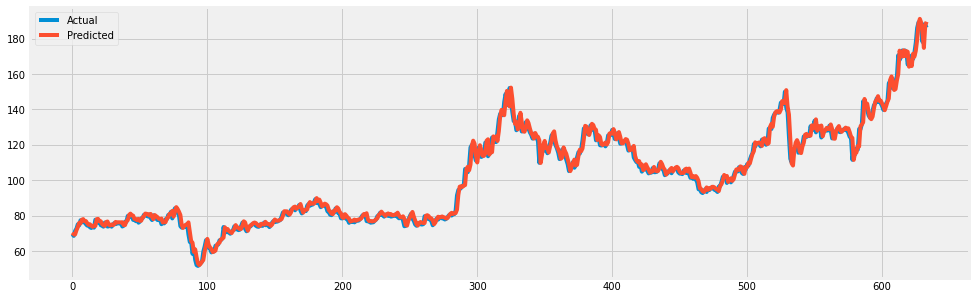

In [62]:
plt.rcParams['figure.figsize'] = (15,5)

MSE = mean_squared_error(y_test, predictions)
R2 = r2_score(y_test, predictions)
RMSE = sqrt(mean_squared_error(y_test, predictions))
MAE = mean_absolute_error(y_test, predictions)

print(MSE)
print(R2)
print(RMSE)
print(MAE)

#plotting predicted test value vs actual test value
plt.plot(y_test, label = 'Actual')
plt.plot(predictions, label = 'Predicted')
plt.legend()
plt.show()

C:\Users\by\AppData\Local\Temp\ipykernel_5044\2178876244.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid["Predictions"] = predictions


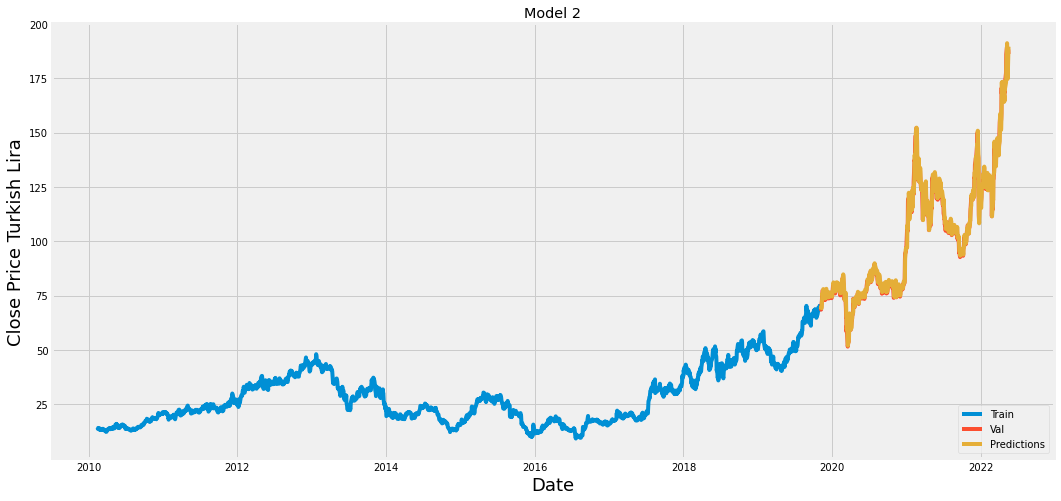

In [63]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid["Predictions"] = predictions
#Visualizing the data
plt.figure(figsize=(16,8))
plt.title("Model 2")
plt.xlabel("Date",fontsize=18)
plt.ylabel("Close Price Turkish Lira",fontsize=18)
plt.plot(train["Close"])
plt.plot(valid[["Close","Predictions"]])
plt.legend(["Train","Val","Predictions"], loc="lower right")
plt.show()